# Example 3. Feature Selection
---

### Import class and data
Wine data is used for the exercises.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df_wine = pd.read_csv('wine.data')
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 
                   'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanolds', 
                   'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 
                   'Hue', 'OD280/OD315 of diluted wines', 'Proline']

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanolds,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
len(df_wine)

178

## Sequential backward selection

In [4]:
from sbs import SBS

In [5]:
from sklearn.neighbors import KNeighborsClassifier

In [6]:
knn = KNeighborsClassifier(n_neighbors=3)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

<sbs.SBS instance at 0x116bf3290>

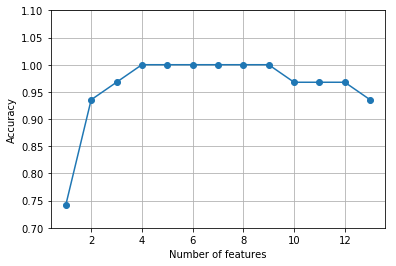

In [7]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()